In [1]:
import numpy as np
import scipy.stats as sps
from tqdm import tqdm
from torchinfo import summary

from utils.utils import *
from utils.noise_gen import *
from utils.training import *
from utils.dataset_loaders import *
from models.basic_models import *

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.io import write_video, write_png
from diffusers import UNet3DConditionModel, DDPMScheduler, DDPMPipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

/home/koltakovmi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/koltakovmi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
%reload_ext autoreload
%autoreload 2

Creating dataset and dataloader for UCF-101 and MovingMNIST.

In [2]:
MovMNIST_frame_dataset = MovMNISTFrameDataset("./datasets/moving_mnist_labeled/")
MovMNIST_frame_dataloader = DataLoader(MovMNIST_frame_dataset, shuffle=True, batch_size=72)

dev = "cuda:5"

model_frame, noise_scheduler_frame, optimizer_frame, lr_scheduler_frame, criterion_frame = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=4,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_frame_dataloader),
    device=dev,
    model_type="image",
    use_labels=True,
)

In [2]:
MovMNIST_dataset = MovMNISTDataset("./datasets/moving_mnist_labeled/")
MovMNIST_dataloader = DataLoader(MovMNIST_dataset, shuffle=True, batch_size=2)

dev = "cuda:1"

model_video, noise_scheduler_video, optimizer_video, lr_scheduler_video, criterion_video = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=4,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device=dev,
    model_type="video",
    use_labels=True,
)

In [5]:
trainer_image = TrainableDiffusionModel(
    model_ref = model_frame,
    optimizer_ref = optimizer_frame,
    lr_scheduler_ref=lr_scheduler_frame,
    noise_scheduler = noise_scheduler_frame,
    criterion = criterion_frame,
    device="cuda:1",
    model_type="image",
    cross_att_dim=4,
    EMA_start=2500,
)

trainer_image.load_state(base_dir_path="./models/trained/mov_mnist_frames_batch96/", suffix="8000",
                   load_optimizer=False, load_lr_sched=False, load_ema_model=False)

# test_losses = trainer.fit(
#     dataloader = MovMNIST_frame_dataloader,
#     save_path = "./models/trained/mov_mnist_frames_batch96/",
#     num_epochs = 4,
# )

In [3]:
trainer_video = TrainableDiffusionModel(
    model_ref = model_video,
    optimizer_ref = optimizer_video,
    lr_scheduler_ref=lr_scheduler_video,
    noise_scheduler = noise_scheduler_video,
    criterion = criterion_video,
    device="cuda:1",
    model_type="video",
    cross_att_dim=4,
    EMA_start=7500,
)

# trainer_video.load_weights_from(trainer_image.model_ref)
# trainer_video.load_weights_from(trainer_image.model_ref, other_type="ema_model")

test_losses = trainer_video.fit(
    dataloader = MovMNIST_dataloader,
    save_path = "./models/trained/test/",
    num_epochs = 4,
)

  0%|                                                                                                                                                                                                                                                             | 0/5000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                                        | 5/5000 [00:29<7:51:11,  5.66s/it, MSE=1.24]

  0%|▏                                                                                                                                                                                                                                        | 5/5000 [00:29<8:10:24,  5.89s/it, MSE=1.24]


KeyboardInterrupt: 

In [7]:
sampler = TrainableDiffusionModel(
    model_ref = model_video,
    optimizer_ref = optimizer_video,
    lr_scheduler_ref=lr_scheduler_video,
    noise_scheduler = noise_scheduler_video,
    criterion = criterion_video,
    device="cuda:1",
    model_type="video",
    EMA_start=5000,
)

sampler.load_state(base_dir_path="./models/trained/labeled_mov_mnist/", suffix="last",
                   load_optimizer=False, load_lr_sched=False, load_ema_model=True)
objects = sampler.sample(num_samples=8,
                         video_length=20,
                         prompts = torch.tensor([1, 11, 27, 54, 32, 45, 48, 23]),
                         override_noise_cov=mixed_noise,
                        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:20<00:00,  5.01s/it]


In [8]:
for i, v in enumerate(objects):
    write_video(
        f"./results/MovMNIST/labeled_video/mixed_noise_{i}.mp4",
        v.repeat(3, 1, 1, 1).permute(1, 2, 3, 0),
        fps=7,
    )

  0%|                                                                                                                                                                                                                                                              | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.16it/s]


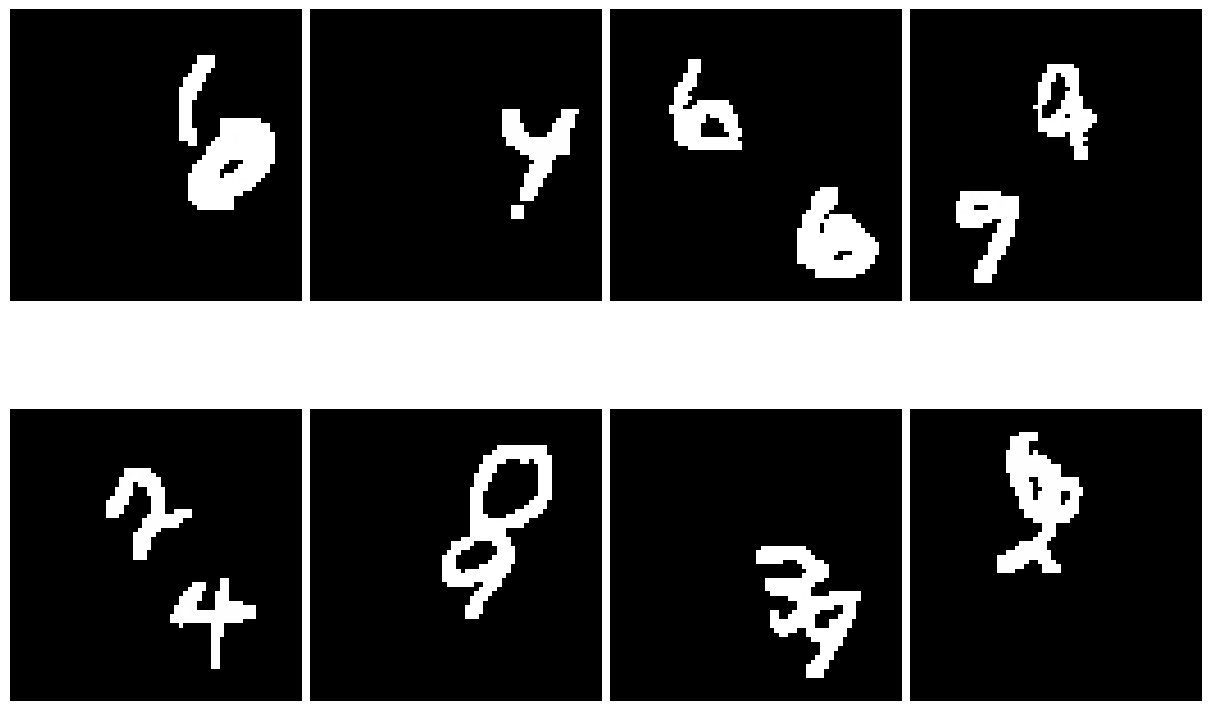

In [4]:
images = sampler.sample(num_samples=8, prompts = torch.tensor([1, 11, 27, 54, 32, 45, 48, 23]))
# images = a.sample.detach().cpu()
# images = ((images.clip(-1, 1) + 1) / 2 * 255).to(torch.uint8)

fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True)
fig.set_size_inches(12, 8)

for i, im in enumerate(images):
    ax[i // 4][i % 4].imshow(im.permute(1, 2, 0), cmap="grey")
    ax[i // 4][i % 4].axis("off")

plt.show()

In [5]:
for i, im in enumerate(images):
    write_png(im, f"results/MovMNIST/labeled_frames/_{i}.png")